panama
101520.31003365997 -34.17719119649182x  +34.177191886256594x  +34.17676697591617x  +11.33628049303245x  +1.6595586559052038e-06x  -0.002445284471053903x  -1.8182809382796294x  +97.29989804351267x  -114.27961660314799x  -269.1754068773055x  +316.9613855543125x 


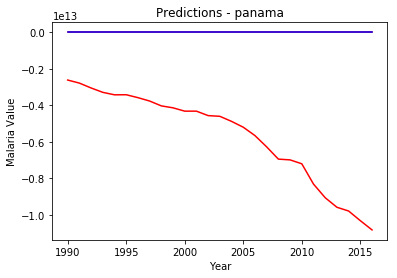

In [2]:

import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
%matplotlib inline

def getWorldbank(filename1):
    #df1 = pd.read_csv('honduras_factors.csv')

    
    df1 = pd.read_csv(filename1)
    df1= df1.replace(0,np.NaN)
    df1 = df1.replace('', np.NaN)

    lastCol= len(list(df1))
    lastRow = len(df1.index)-5  #the last row we want to take data (to remove world bank credits)

    #dont change the order of code below!
    df1.drop(df1.index[lastRow:], inplace=True)
    df1.drop(list(df1)[lastCol-2:lastCol],axis=1, inplace=True)
    df1.drop('Country Name', axis=1, inplace=True)
    
    df1.drop(list(df1)[1:22],axis=1, inplace=True)  #delete select columns (years) from input file
    df1.dropna(axis=0, inplace=True)
    
    df1.set_index('Series Name',inplace=True) #choose 'Series Name' to be the new index
    dfT = df1.T
    dfT = dfT.reset_index()   #reset index - required for OLS format
    newName = filename1[:-4]
    newName = newName + 'Factors.csv'
    dfT.to_csv(newName, encoding='utf-8')
    lenCol= len(list(dfT))  #to find number of columns of pruned table
    X = dfT[list(dfT)[1:lenCol]]  #take all columns for analysis except for 1st column(year) 
    X = sm.add_constant(X)
    return X

def getMalariaCountry(filename2):    
    #df2 = pd.read_csv('honduras_1990-2016.csv')
    df2 = pd.read_csv(filename2)
    colname = list(df2)[1]
    y = df2[colname]
    return y

def saveResults(modelName, countryName, predictEqName):
#    with open('myresults.csv', 'w') as f:
#    f.write(model.summary().as_csv())
    filename = countryName + 'Results.txt'
    f = open(filename, 'w')
    f.write(model.summary().as_text()+'\n\n') #just another way to convert to str
    f.write(str(modelName.params)+'\n\n')
    f.write(str(modelName.pvalues)+'\n\n')
    f.write(str(predictEqName))
    f.close()
    return

def findFeatures(maxFeatures, y, x):   
    lenCol = len(list(x))               #added to fix missing variable lenCol
    subset = x[list(x)[1:lenCol]]    #list is pandas builtin function to get header list
    while(len(subset.columns) > maxFeatures):
        subsetNames = []
        end = len(subset.columns) - 20
        if(len(subset.columns) < 20):
            end = len(subset.columns)
        for i in range(0, end, 20):
            subsetNames.extend(backward_select(subset[list(subset)[i:i+20]], y,  list(subset[list(subset)[i:i+20]].columns.values), maxFeatures))
        subset = x[subsetNames]
    return subset


def backward_select(df, y, remaining_features, maxFeatures):
    SSE = 0
    while True:
        X = df[remaining_features]
        X = sm.add_constant(X)
        model = sm.OLS(y, X).fit()
        yhat = model.predict(X)
        SSE=((y-yhat)**2).sum()
        maxVal = 0
        index = 0 
        a = model.pvalues
        for val in range(0,len(a)):
            if a[val] > maxVal:
                maxVal = a[val]
                index = val
        if len(remaining_features) > maxFeatures:
            #print(remaining_features[index-1],", SSE:",SSE)
            del remaining_features[index-1]
        else:
            break
    return list(remaining_features)

countryFactorFile = 'panama.csv'
countryMalariaFile = 'Panama_1990-2017.csv'
countryStr = countryFactorFile[:-4]

print(countryStr)

x = getWorldbank(countryFactorFile)    
y = getMalariaCountry(countryMalariaFile)

#Use findfeatures function with any number between 1-19
#df2 = pd.read_csv('honduras_1990-2016.csv')  replaced by line below
df2 = pd.read_csv(countryMalariaFile)

#dfWeather = pd.read_csv('../HondurasWeather1990-2016.csv')
#y = df2['Honduras'] #replaced w function : y = getMalariaCountry(filename)

dfSubset = findFeatures(11, y, x)  #replaced dfT with x
X = dfSubset
X = sm.add_constant(X)

X.to_csv(countryStr + 'TopFactors.csv', encoding = 'utf-8')
model = sm.OLS(y, X).fit()

#print(model.summary())
#print(model.params)
#print(model.pvalues)
predictionArray = []
predictionEq = str(model.params[0])
for j in range(1, len(model.params)):
    if(model.params[j] < 0):
        predictionEq +=  ' '+str(model.params[j])+'x '
    else:
        predictionEq += ' +'+str(model.params[j])+'x '

for y in range(0, len(y)):
    prediction = model.params[0]
    for i in range(1, len(dfSubset.columns)):
        prediction += model.params[i]* dfSubset[list(dfSubset)[i-1]][y]
    predictionArray.append((1990+y,prediction))

print(predictionEq)

plt.plot(range(1990,2017),predictionArray, color='r')
plt.plot(range(1990,2017),df2['Datum'], color='b')   #note !!!code will break if 'Datum' not in countryMalariaFile
plt.title("Predictions - "+ countryStr)
plt.xlabel('Year')
plt.ylabel('Malaria Value')
plt.savefig(countryStr+'Plot.jpg',bbox = 'tight')
plt.show()


saveResults(model, countryStr, predictionEq)

